In [1]:
#!pip install jax
#!pip install -U "jax[cpu]"
#!pip install mat73
#!pip install scikit-learn-extra 
# Comment out the lines above after running them once. 
#!pip install pandas
#!pip install seaborn

# Importing the libraries
import sys
import psutil
import time
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import scipy
from scipy import signal
from scipy.signal import find_peaks
import json
import mat73
import math
import os
import pandas as pd
import seaborn as sns


In [2]:
def compare_sources(list1, list2, tolerance):
    #tolerance = 5
    duplicate_matches = 0

    list1_matches = set()
    list2_matches = set()
    list1_duplicates = set()
    list2_duplicates = set()

    for  spike_idx in list1:
        for spike2_idx in list2:
            #print(f'Cheking: {spike_idx} & {spike2_idx}')
            #print(f'Difference: {abs(spike_idx-spike2_idx)}')

            if  abs(spike_idx-spike2_idx) < tolerance:  
                if spike_idx not in list1_matches and spike2_idx not in list2_matches:
                    
                    # Add the spike pair to the matched spikes
                    list1_matches.add(spike_idx)
                    list2_matches.add(spike2_idx)

                else:
                    # Add the spike pair to the duplicate list
                    list1_duplicates.add(spike_idx)
                    list2_duplicates.add(spike2_idx)

                    # Incriment the duplicate counter
                    duplicate_matches += 1


            if (spike_idx - spike2_idx) < - tolerance:
                #print('There is no way back!')
                break

    list1_duplicates = list1_duplicates - list1_matches
    list2_duplicates = list2_duplicates - list2_matches

    matched_count = len(list1_matches) + len(list2_matches)
    spikes_with_duplicates = len(set(list1_duplicates)) + len(set(list2_duplicates))
    unmatched_count = len(list1) + len(list2) - matched_count - len(list1_duplicates) - len(list2_duplicates)
    rate_of_agreement = (matched_count / (matched_count + unmatched_count + spikes_with_duplicates)) * 100
    print("Start")
    print(matched_count)
    print(unmatched_count)
    print(spikes_with_duplicates)
    print(len(list1))
    print(len(list2))
    print(rate_of_agreement)
    print("\n")

    return matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement

In [3]:
# Fetch the true sources
file_path = '../data/SIMULATION_56_40.mat'
# Create a dictionary from the matlab data file.
data_dict = scipy.io.loadmat(file_path)

# Extract the EMG spike data into a numpy array
MUPulses = np.array(data_dict['MUPulses'][0])
print(MUPulses.shape)
print(MUPulses[40].shape)

(56,)
(1, 719)


In [11]:
# Fetch the true sources
file_path_mat = '../data/matlabSpikes50.mat'
# Create a dictionary from the matlab data file.
data_dict_mat = scipy.io.loadmat(file_path_mat)


# Extract the EMG spike data into a numpy array
MUPulsesMat = np.array(data_dict_mat['spikeMat'])


spikeList = []
for idx in range(len(MUPulsesMat)):
    sourceList = []
    for index, value in enumerate(MUPulsesMat[idx]):
        if value == 1:
            sourceList.append(index)
    spikeList.append(sourceList)


In [22]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
dup_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        sourceB = sourceB['SpikeTrain']
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))

        matched_count, spikes_with_duplicates, unmatched_count, rate_of_agreement = compare_sources(sourceA, sourceB, roa_tolerance)

        roa_matrix.iloc[idxA, idxB] = np.round(rate_of_agreement).astype(int)
        dup_matrix.iloc[idxA, idxB] = spikes_with_duplicates

    loopidx = 1

print(roa_matrix)
print(dup_matrix)

(56, 14)
Start
674
826
0
760
740
44.93333333333333


Start
566
912
0
760
718
38.29499323410013


Start
598
925
0
760
763
39.26460932370322


Start
538
935
0
760
713
36.52410047522064


Start
566
913
0
760
719
38.269100743745774


Start
570
925
0
760
735
38.12709030100335


Start
500
1001
0
760
741
33.311125916055964


Start
614
863
0
760
717
41.570751523358155


Start
564
883
0
760
687
38.977194194885975


Start
578
905
0
760
723
38.975050573162505


Start
634
831
0
760
705
43.27645051194539


Start
574
911
0
760
725
38.65319865319865


Start
544
921
0
760
705
37.13310580204778


Start
640
823
0
760
703
43.74572795625427


Start
568
929
0
757
740
37.94255177020708


Start
546
929
0
757
718
37.016949152542374


Start
696
824
0
757
763
45.78947368421053


Start
584
886
0
757
713
39.72789115646258


Start
534
942
0
757
719
36.17886178861789


Start
558
934
0
757
735
37.39946380697051


Start
670
828
0
757
741
44.726301735647525


Start
576
898
0
757
717
39.07734056987788


Start
560
884
0

In [4]:
def create_binary_list(indices, total_length):
    """
    Create a binary list where indices are marked as 1s.
    """
    binary_list = [0] * (total_length+1)
    for index in indices:
        binary_list[index] = 1
    return binary_list

def calculate_rate_of_agreement(list1, list2):
    """
    Calculate the rate of agreement between two lists of spike indices.
    """
    total_indices = len(list1)+len(list2)
    max_length = max(list1[-1], list2[-1])
    max_agreement = 0
    best_shift = 0
       # Create binary lists for list1 and list2
    binary_list1 = create_binary_list(list1, max_length)
    binary_list2 = create_binary_list(list2, max_length)


    # Iterate through possible shifts
    for shift in range(-10, 11):
        agreement_count = 0

        # Shift binary_list1 by shift amount
        shifted_binary_list1 = [0] * max_length
        if shift < 0:
            shifted_binary_list1[-shift:] = binary_list1[:shift]
        elif shift > 0:
            shifted_binary_list1[:-shift] = binary_list1[shift:]


 
        # Perform element-wise multiplication and sum
        for i in range(max_length):
            agreement_count += shifted_binary_list1[i] * binary_list2[i]

        # Calculate rate of agreement for current shift
        rate_of_agreement = (agreement_count * 2 / total_indices) * 100

        # Update max agreement and best shift if current shift has higher rate of agreement
        if rate_of_agreement > max_agreement:
            max_agreement = rate_of_agreement
            best_shift = shift

    return best_shift, max_agreement

# Example usage
list1 = [1, 3, 5, 7, 9]
list2 = [2, 4, 6, 8, 10]
shift, rate_of_agreement = calculate_rate_of_agreement(list1, list2)
print("Best shift:", shift)
print("Rate of agreement:", rate_of_agreement)

Best shift: -1
Rate of agreement: 80.0


In [16]:
roa_tolerance = np.round(1 * 0.008 / (1/4096))
MUPulsesA = MUPulses

# Opening JSON file
f = open('../data/output2.json')
# returns JSON object as 
# a dictionary
MUPulsesB = json.load(f)
 # Closing file
f.close()
#MUPulsesB = spikeList

roa_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))
shift_matrix = pd.DataFrame(0, index=range(len(MUPulsesA)), columns=range(len(MUPulsesB)))

spikeCountTrue = []
spikeCountCalc = []

print(roa_matrix.shape)
loopidx = 0
# Looping through the sources A and sources B and computing their mutual rate of agreement.
for idxA, sourceA in enumerate(MUPulsesA):
    sourceA = sourceA[0] # This line is required for the ground truth sources, as they have a slightly different format.
    spikeCountTrue.append(len(sourceA))
    for idxB, sourceB in enumerate(MUPulsesB):
        print(idxA, idxB)
        sourceB = sourceB["SpikeTrain"]
        if loopidx <1:
            spikeCountCalc.append(len(sourceB))


        shift, rate_of_agreement = calculate_rate_of_agreement(sourceA, sourceB)

        
        roa_matrix.iloc[idxA, idxB] = rate_of_agreement 
        shift_matrix.iloc[idxA, idxB] = shift 


    loopidx = 1

print(roa_matrix)


(56, 14)
0 0
0 1
0 2


/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2178619756427604' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4445173998686802' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 3
0 4
0 5


/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3577732518669383' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0818120351588911' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0702341137123745' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 6
0 7
0 8


/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.1992005329780147' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2186865267433988' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.10573600552868' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 9
0 10
0 11


/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.3486176668914363' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0921501706484642' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.2121212121212122' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


0 12
0 13
1 0


/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0921501706484642' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement
/tmp/ipykernel_90915/2073417149.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.367053998632946' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  roa_matrix.iloc[idxA, idxB] = rate_of_agreement


1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
16 0
16 1
16 2
16 3


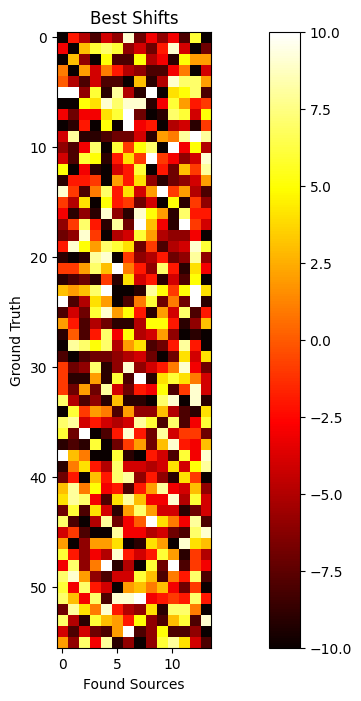

In [14]:
# Step 3: Plot the Heatmap
plt.figure(figsize=(15, 8))
plt.imshow(shift_matrix, cmap='hot', interpolation='nearest')

# Step 4: Customize the Plot (Optional)
plt.colorbar()  # Add color bar
plt.xlabel('Found Sources')
plt.ylabel('Ground Truth')
plt.title('Best Shifts')

# Step 5: Show or Save the Plot
plt.show()

In [21]:
max_index = np.unravel_index(np.argmax(roa_matrix), roa_matrix.shape)

print("Indices of the maximum value:", max_index)

Indices of the maximum value: (0, 31)


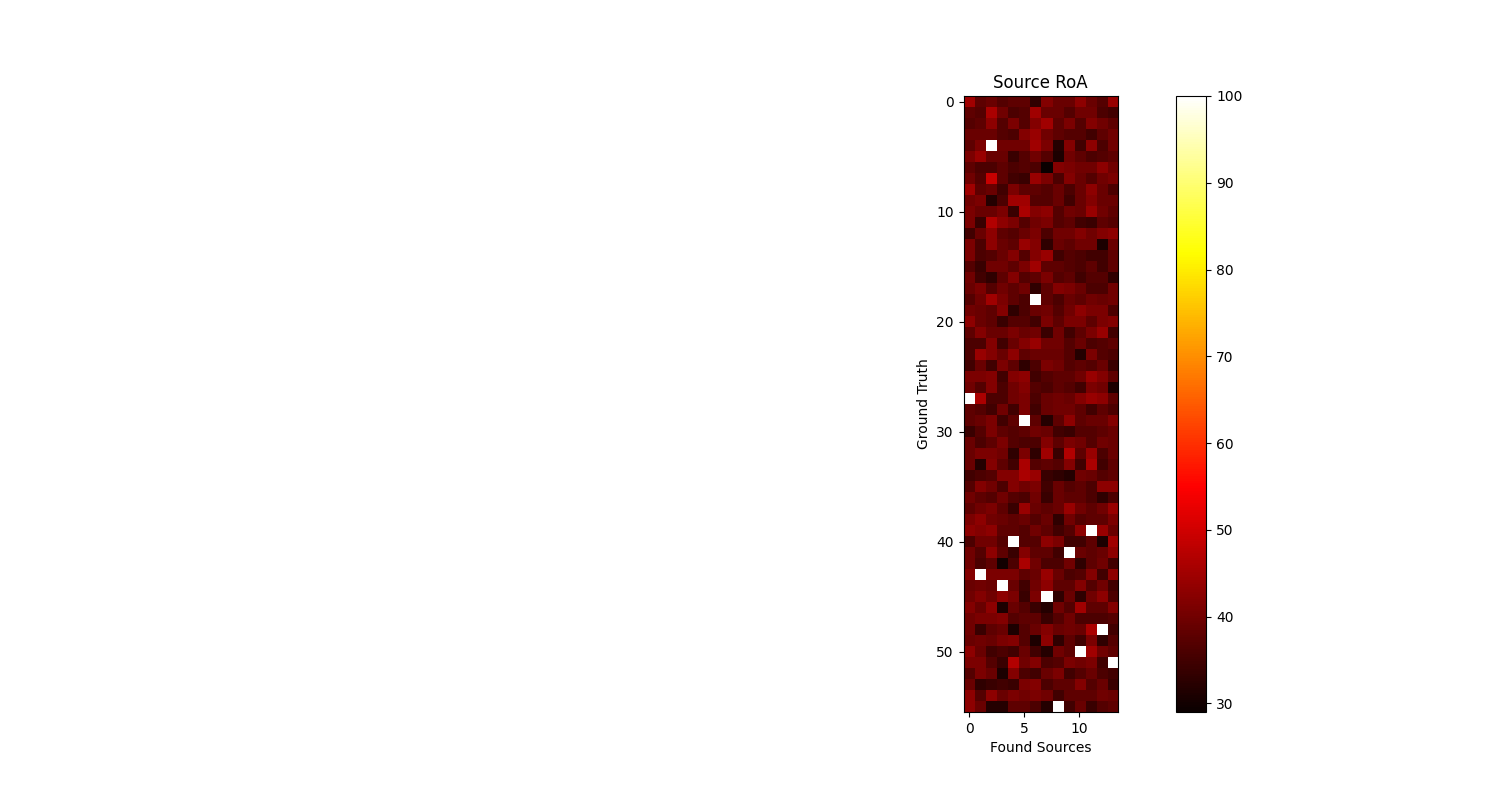

In [23]:
# Step 3: Plot the Heatmap
plt.figure(figsize=(15, 8))
plt.imshow(roa_matrix, cmap='hot', interpolation='nearest')

# Step 4: Customize the Plot (Optional)
plt.colorbar()  # Add color bar
plt.xlabel('Found Sources')
plt.ylabel('Ground Truth')
plt.title('Source RoA')

# Step 5: Show or Save the Plot
plt.show()

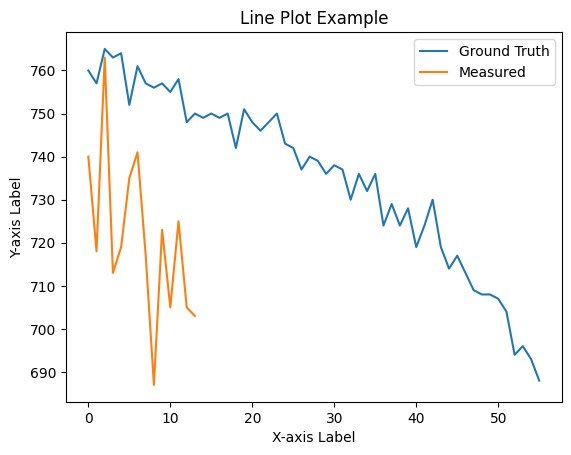

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first line
sns.lineplot(spikeCountTrue, label='Ground Truth', ax=ax)

# Plot the second line
sns.lineplot(spikeCountCalc, label='Measured', ax=ax)

# Add labels and title
ax.set_xlabel('X-axis Label')
ax.set_ylabel('Y-axis Label')
ax.set_title('Line Plot Example')

# Show the legend
ax.legend()

# Display the plot
plt.show()

In [ ]:
print(shift_matrix[0][18])

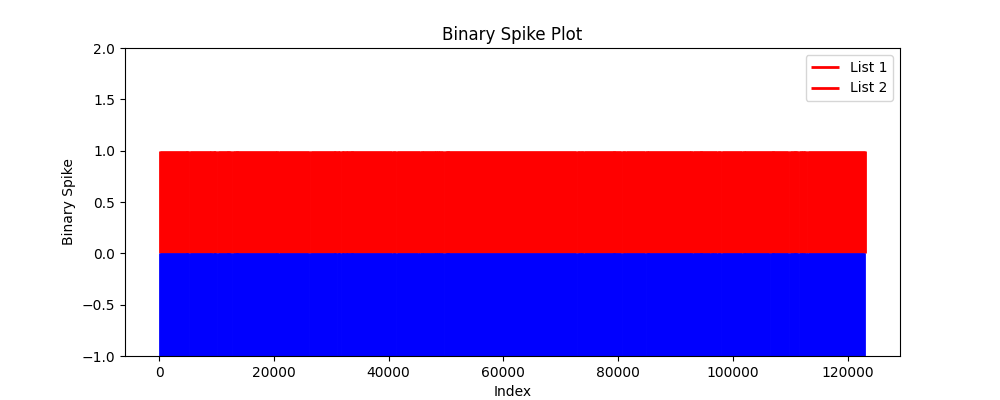

29
37


In [25]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[50][0]
list2 = MUPulsesB[10]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()
print(roa_matrix[7][6])
print(roa_matrix[5][1])

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[6][0]
list2 = MUPulsesB[5]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
for list in MUPulsesB:
    plt.figure(figsize=(15, 2))
    time_interval_indices = np.divide(list["SpikeTrain"], 4096)
    plt.vlines(time_interval_indices, 0,1, color='black', linestyle='solid', label='Spikes')
    # Customize the plot as needed
    plt.xlim([0,30])
    plt.xlabel('Time in S')
    plt.title('Spike Train')
    plt.legend()
    plt.show()

In [ ]:
print(np.divide(list2,2))

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# Define the two lists of spike indices
list1 = MUPulsesA[30][0]
list2 = MUPulsesB[12]["SpikeTrain"]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 4))

# Set the y-axis limits
ax.set_ylim(-1, 2)

# Plot the first list of spike indices
for i in list1:
    ax.vlines(i, 0, 1, colors='r', linewidth=2)

# Plot the second list of spike indices
for i in list2:
    ax.vlines(i, 0, -1, colors='b', linewidth=2)

# Add labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Binary Spike')
ax.set_title('Binary Spike Plot')

# Add legend
ax.legend(['List 1', 'List 2'], loc='upper right')

# Display the plot
plt.show()

In [ ]:
sns.heatmap(roa_matrix, cmap='coolwarm')

In [ ]:
sns.heatmap(dup_matrix, cmap='coolwarm')